In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c quora-question-pairs

 93% 286M/309M [00:04<00:00, 29.4MB/s]
100% 309M/309M [00:04<00:00, 75.4MB/s]


In [ ]:
!unzip /content/quora-question-pairs.zip

Archive:  /content/quora-question-pairs.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [ ]:
!unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [ ]:
import pandas as pd
dataset = pd.read_csv('/content/train.csv',index_col=False)

In [ ]:
dataset.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
113757,113757,185832,45639,Why are some people reluctant to stay at an ai...,"If Airbnb is just as expensive as a hotel, why...",0
246369,246369,359405,359406,Do Spetsnaz and the US Special forces have a b...,What percentage of US Special Forces soldiers ...,0
46655,46655,83427,83428,What are some of the great books about India w...,What are the must-read books about India?,1
296215,296215,418390,418391,Hows Career of computer engineer is like after...,Hows Career of computer engineer working as te...,0
157992,157992,246896,246897,Do you think that a new coup is possible in Tu...,Is it likely that there will be another milita...,1


In [ ]:
dataset = dataset.drop(['id','qid1','qid2'],axis=1)

In [ ]:
dataset = dataset.dropna()

In [ ]:
dataset = dataset.drop_duplicates()

In [ ]:
import re

def clean_text(text)->str:
  text = text.lower()
  text = re.sub('\[.*?\]','',text)
  text = re.sub('https?://\S+|www\.\S+','',text)
  text = re.sub('<.*?>+','',text)
  text = re.sub('\n','',text)
  text = re.sub(r'[^\w]',' ',text)
  text = re.sub('\w*\d\w*','',text)
  return text

dataset.question1 =dataset.question1.map(clean_text)
dataset.question2 =dataset.question2.map(clean_text)

array([[<Axes: title={'center': 'is_duplicate'}>]], dtype=object)

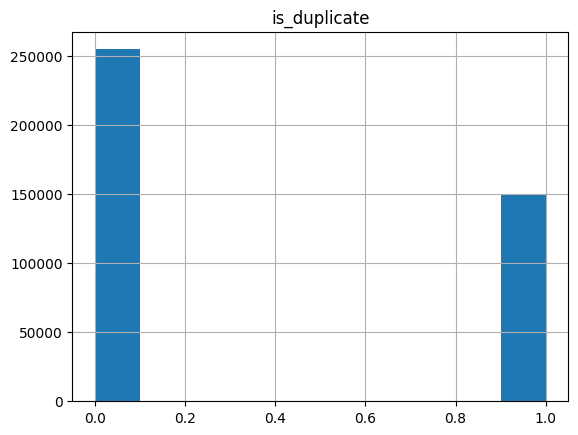

In [ ]:
dataset.hist()

In [ ]:
dataset = pd.concat([
    dataset[(dataset.is_duplicate==1)],
    dataset[(dataset.is_duplicate==0)].iloc[:149263]
])

In [ ]:
from sklearn.model_selection import train_test_split

train , test = train_test_split(dataset,
                                train_size=0.8,test_size=0.2,
                                stratify=dataset['is_duplicate'],random_state=42)

In [ ]:
import tensorflow as tf

In [ ]:
vocab_size:int = 10_000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words = vocab_size,
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
    oov_token='<OOV>')

# fitting
tokenizer.fit_on_texts(dataset.question1)

In [ ]:
def tokenize(Tokenizer,text):
  tensor = tokenizer.texts_to_sequences(text)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
  return tensor

In [ ]:
train_question1_tensor = tokenize(tokenizer,train.question1)
train_question2_tensor = tokenize(tokenizer,train.question2)

test_question1_tensor = tokenize(tokenizer,test.question1)
test_question2_tensor = tokenize(tokenizer,test.question2)

In [ ]:
y_train = train.is_duplicate
y_test = test.is_duplicate

In [ ]:
def dataset(q1,q2,y):
  data = tf.data.Dataset.from_tensor_slices(((q1,q2),y))
  data = data.shuffle(1028)
  data = data.batch(32,drop_remainder=True)
  data = data.prefetch(tf.data.experimental.AUTOTUNE)
  return data
train_dataset = dataset(train_question1_tensor,train_question2_tensor,y_train)
test_dataset = dataset(test_question1_tensor,test_question2_tensor,y_test)

# siames networks

In [ ]:
class SiamesModel(tf.keras.Model):
  def __init__(self):
    super(SiamesModel,self).__init__()

    self.l1 = tf.keras.layers.Embedding(input_dim=vocab_size+1,
                                        output_dim=128,
                                        mask_zero=True)

    self.l2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(
                                            units=64,
                                            return_sequences=False,return_state=True))

    self.l3 = tf.keras.layers.Dense(256,activation='leaky_relu',
                                    kernel_initializer= tf.initializers.he_uniform)

    self.l4 = tf.keras.layers.Dropout(0.3)

    self.l5 = tf.keras.layers.Dense(units=1,activation=tf.nn.sigmoid)

  def call(self,input):
    x1 = input[0]
    x2 = input[1]
    #------------
    x1 = self.l1(x1)
    x2 = self.l1(x2)
    #------------
    x1 , hidden1 , hidden2 = self.l2(x1)
    x2 , _ , _ = self.l2(x2, [hidden1,hidden2])
    #------------
    x = tf.keras.layers.concatenate([x1,x2])
    x = self.l3(x)
    x = self.l4(x)
    output = self.l5(x)
    return output

  def build_model(self):
    x = tf.keras.layers.Input(shape=(300,))
    return tf.keras.Model(inputs=x,outputs=[self.call((x,x))])

In [ ]:
model = SiamesModel()
model.build_model().summary(line_length=100)

Model: "model_3"
____________________________________________________________________________________________________
 Layer (type)                 Output Shape                  Param #   Connected to                  
 input_5 (InputLayer)         [(None, 300)]                 0         []                            
                                                                                                    
 embedding_6 (Embedding)      (None, 300, 128)              1280128   ['input_5[0][0]',             
                                                                       'input_5[0][0]']             
                                                                                                    
 bidirectional_6 (Bidirectio  [(None, 128),                 74496     ['embedding_6[0][0]',         
 nal)                          (None, 64),                             'embedding_6[1][0]',         
                               (None, 64)]                             'bi

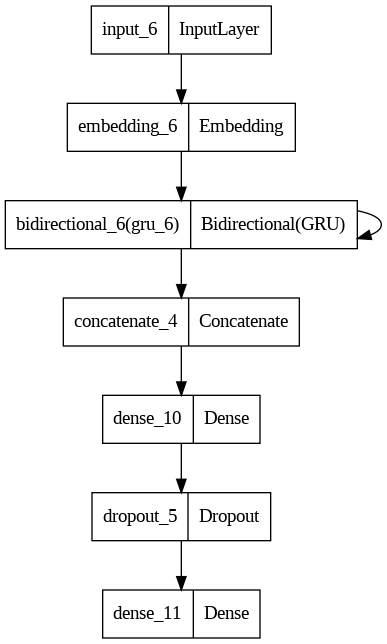

In [ ]:
tf.keras.utils.plot_model(model.build_model())

In [ ]:
model.compile('adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.fit(train_dataset,epochs=5,validation_data=test_dataset)

Epoch 1/5
7463/7463 [==============================] - 184s 23ms/step - loss: 0.5037 - acc: 0.7526 - val_loss: 0.4582 - val_acc: 0.7825
Epoch 2/5
7463/7463 [==============================] - 150s 20ms/step - loss: 0.4003 - acc: 0.8178 - val_loss: 0.4541 - val_acc: 0.7941
Epoch 3/5
7463/7463 [==============================] - 150s 20ms/step - loss: 0.3170 - acc: 0.8642 - val_loss: 0.5078 - val_acc: 0.7887
Epoch 4/5
7463/7463 [==============================] - 150s 20ms/step - loss: 0.2475 - acc: 0.8979 - val_loss: 0.5887 - val_acc: 0.7848
Epoch 5/5
7463/7463 [==============================] - 162s 22ms/step - loss: 0.1935 - acc: 0.9230 - val_loss: 0.6975 - val_acc: 0.7810


In [ ]:
import numpy as np
print('accuracy: ',np.round(model.evaluate(test_dataset)[1]*100),'%')

1865/1865 [==============================] - 14s 7ms/step - loss: 0.6973 - acc: 0.7811
accuracy:  78.0 %
